# Chapter 2

In this notebook we will be implementing implementing the code based on the code snippets presented in the book [Learning OpenCV 3 Computer Vision with Python](https://www.packtpub.com/application-development/learning-opencv-3-computer-vision-python-second-edition). Though the examples here arent exactly same as those in the book, they are close enough. I have taken liberty to make changes as to understand the concepts better

---

After the required imports, we will create a numpy array of size 2 X 2 and then convert this array to BGR format. Remember, the three channels in OpenCV will be BGR and not RGB. The 2 X 2 input array will be a Grayscale image

In [1]:
import cv2
import numpy as np
import time
%matplotlib inline
import matplotlib.animation as animation
import matplotlib.pyplot as plt


In [2]:
gray_scale = np.array([[1, 2], [3, 4]], dtype = np.uint8)
bgr_image = cv2.cvtColor(gray_scale, cv2.COLOR_GRAY2BGR)

From the above two lines following things are important to note 

- the numpy array for gray scale is 2D and specifying the dtype = np.unit8 is important else we will get an error
- the cv2.cvrColor (stands for Convert Color) accepts the source image to convert and the type to convert to.

Let's look at the number of channels in the gray_scale and bgr image by inspecting the shape of the two image arrays and also by printing out the contents of bgr_image

In [3]:
print('Shape of gray scale image is', gray_scale.shape)
print('Shape of bgr image is', bgr_image.shape)
print('\nContents of the bgr_image are', bgr_image)

Shape of gray scale image is (2, 2)
Shape of bgr image is (2, 2, 3)

Contents of the bgr_image are [[[1 1 1]
  [2 2 2]]

 [[3 3 3]
  [4 4 4]]]


---

Note how the 3rd dimension of size 3 was added to the source gray scale image and the same value in two dimenension got copied over to the three dimensions

Now, let's look at the following image icon for python programming language.

![Python](python.png)

---

Lets read this image using OpenCV and do the following

- Load the image
- Check the type of the value read, should be np.ndarray
- Convert to 1D byte vector using Python's bytearray method
- Check the length of the 1D Byte vector
- Check the shape of the image's ndarray and ensure the product of the values of the three dimensions is same as the length of the 1D byte vector
- Check the max and min values of the pixels in the image


In [4]:
image = cv2.imread('python.png')
l = bytearray(image)
print('Length of the 1D vector is', len(l))
dim = image.shape
print('Shape of the image ndarray is', dim, 'product of the three values is', (dim[0] * dim[1] * dim[2]))
print('Max value of the pixel value is', max(l), ', min value is', min(l))
      

Length of the 1D vector is 12288
Shape of the image ndarray is (64, 64, 3) product of the three values is 12288
Max value of the pixel value is 255 , min value is 0


---

Lets create two random images, each of size 25 X 25. First one is a Gray scale image with just one channel and the second one will be the one of size 25 X 25 but each pixel having 3 channels

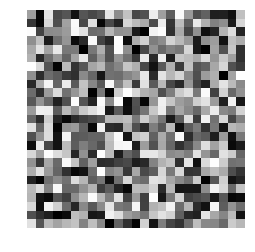

In [5]:
gray25by25 = np.reshape(np.random.randint(0, 255, 25 * 25, dtype = np.uint8), (25, 25))
plt.imshow(gray25by25, cmap='gray')
plt.axis('off')
plt.show()

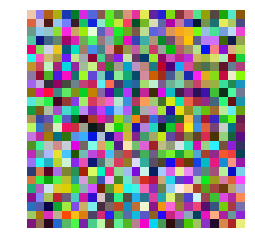

In [6]:
colorimage = np.reshape(np.random.randint(0, 255, 25 * 25 * 3, dtype = np.uint8), (25, 25, 3))
plt.imshow(colorimage)
plt.axis('off')
plt.show()

The same color image when converted to single channel Gray scale and plotted looks like follows

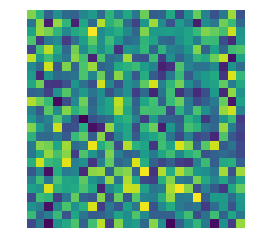

In [7]:
plt.imshow(cv2.cvtColor(colorimage, cv2.COLOR_BGR2GRAY))
plt.axis('off')
plt.show()

Let's now use numpy to vectorize image cube. Here we will perform the following two operations

- we will set all the blue channel of the image to 0. We then plot it to see the difference. Note that OpenCV stores images in BGR format and pyplot interprets it as RGB. Thus for the sake of displaying the image without the blue component, after settinh the 0th channel(Blue) to 0, we convert it to RGB format before we pass it to pyplot's imshow function
- Set the left cornet patch of 10 X 10 to black

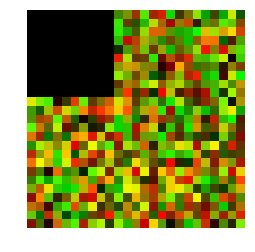

In [8]:
colorimage_copy = colorimage.copy()
colorimage_copy[0:10, 0:10, :] = 0
colorimage_copy[:, :, 0] = 0
plt.imshow(cv2.cvtColor(colorimage_copy, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

---

## Capturing images using a camera

I have skipped the part from the chapter related to videos in the Chapter and will update the notebook later. Currently my goal is to know about capturing image frames from the camera and analyze the captured frames.

For rest of the section I assume we have a Webcam available, either integrated in the monitor or an external one. The subsequent section will start your webcam, capture your image (or whatever is in front of the camera) and display it on to the notebook. Note how the captured frame needs to be converted to RGB. Following code plots the captured frame, both with and without conversion to RGB.

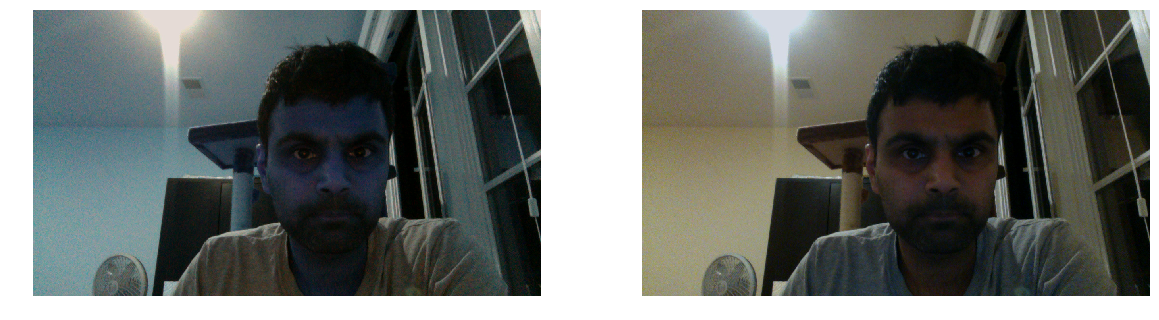

In [9]:
cameraCapture = None
try:
    cameraCapture = cv2.VideoCapture(0)
    success, frame = cameraCapture.read()
    if success:
        f, axis = plt.subplots(1, 2)
        f.set_size_inches((20, 10))
        axis[0].imshow(frame)
        axis[1].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        axis[0].axis('off')
        axis[1].axis('off')
        plt.show()
finally:
    if cameraCapture  is not None:            
        cameraCapture.release()


### Project Cameo, A project for face tracking and image manipulation

---

We will start with some abstraction and create a couple of classes 

Before we start looking at the class ``CaptureManager`` lets get familiar with some of the concepts. Following image is a [Kinect](https://en.wikipedia.org/wiki/Kinect) device for XBox 360 and is an example of a multi camera device. If we look closely we have more than one cameras present to capture the image.

![KinectCamera](kinectCamera.jpg)

Now that we know what a multi camera is lets look at some of the methods of the ``cv2.VideoCapture`` class

- ``grab``: The method grabs the next frame from video file or camera. The return value is a boolean value having value True, in case of success. This is primarily used in Multi camera environment when we want to capture frames from multiple cameras where the capture time is very close to each other. The grab method is followed by a slower method retrieve which decodes and gets the frame from each camera. Usually the grab and retrieve is called back to back for different channels to get the captured frame from a Multi Head camera very close in time space.


- ``retrieve``:The retrieve method  decodes and returns the grabbed video frame the first return argument is boolean True or False whether Frames have been grabbed or not and the second parameter is for getting the captured frame. The value is None if nothing is captured and hence we can ignore the first return value


In [10]:
class CaptureManager:
    
    #
    # capture is an instance of cv2.VideoCapture
    #
    def __init__(self, capture, previewWindowManager = None, shouldMirrorPreview = False):
        self.previewWindowManager = previewWindowManager
        self.shouldMirrorPreview = shouldMirrorPreview
        
        #An instance of cv2.VideoCapture
        self._capture = capture        
        self._channel = 0
        #Set if enterFrame is invoked on the instance
        self._enteredFrame = False
        # the actual property holding the last captured frame by VideoCapture. This 
        # variable is wrapped by the frame property defined in the class.
        #FPS Estimate is in place only if we intend to write videos captured
        self._frame = None
        self._startTime = None
        self._framesElapses = 0
        self._fpsEstimate = None
    
    def __enter__(self):
        return self
    
    
    def __exit__(self, exc_type, exc_value, traceback):
        self._capture.release()
        
    
    #In Python anything annotated with a @property acts as  a read property. 
    #The name of the property is same as the name of the method. For e.g, below method has a property named channel
    #If we want to provide a setter for the channel, we will provide another method channel and annotate it with 
    #@<property name>.setter
    
    @property    
    def channel(self):
        return self._channel
    
    
    @channel.setter
    def channel(self, value):
        if self._channel != value:
            self._channel = value
            self._frame = None
            
    @property        
    def frame(self):
        if self._enteredFrame and self._frame is None:
            # invokes retrieve only if enterFrame(defined later in the class) on this instance is called.
            # The retrieve method  decodes and returns the grabbed video frame
            # the first return argument is boolean True or False whether Frames have been grabbed or not and
            # the second parameter is for getting the captured frame. The value is None if nothing is captured and
            # hence we can ignore the first return value
            _, self._frame = self._capture.retrieve()
            
        return self._frame
            
    # We intend to skip all the code which writes to file system and want to keep the code/data in the notebook(Kernel) 
    # as far as possible
    
    def enterFrame(self):
        #Start grabbing the next frame
        assert not self._enteredFrame, 'enterFrame() already invoked without calling its exitFrame()'
        self._enteredFrame = self._capture.grab()
        
    
    def exitFrame(self):
        #1. Check if we have entered the frame, if no 
        if self.frame is None:
            self._enteredFrame = False
            return
        
        #We have a frame, update fps estimate
        if self._startTime is None:
            self._startTime = time.time()
        else:
            timeElapsed = time.time() - self._startTime
            self._fpsEstimate = self._framesElapses / timeElapsed
            self._framesElapsed += 1
            
        if self.previewWindowManager is not None:
           if self.shouldMirrorPreview:
               mirrored = np.fliplr(self.frame)
               self.previewWindowManager(mirrored)
           else:
               self.previewWindowManager(self.frame)
                
        
        self._frame = None
        self._enteredFrame = False

With the above class defined which lets us capture frames, we can, if desired extend this class to display a video from a sequence of frame. 

We can call ``enterFrame`` method on the ``CaptureManager`` for multiple cameras. This method is inexpensive than the ``frame`` method that calls ``retrieve`` on ``cv2.VideoCapture`` class. We then can call ``frame`` method any number of times as the frame is then cached in until we call ``exitFrame``.

Following code snippet is a small sample usage of the class.

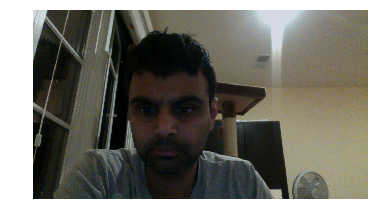

In [11]:
with CaptureManager(cv2.VideoCapture(0)) as cm:    
    assert cm.frame is None, 'Expected None frame as enter frame not called'
    cm.enterFrame()
    frame = cm.frame
    assert frame is not None, 'Expected Frame to be present'
    cm.exitFrame()
    assert cm.frame is None, 'Expected None frame as exit frame called'
    #Display mirror like image of the camera
    plt.imshow(np.fliplr(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)))
    plt.axis('off')
    plt.show()

We will use this class going forward (copying the content in another notebook) and add more functionalities to it. The objective if to detect faces in the given image.